In [219]:
import qiskit as qt
import numpy as np
from qiskit import Aer
import time

Function to be minimized is ,
$$
y = -5 x_1 - 3 x_2 - 8 x_3 - 6 x_4 + 4 x_1 x_2 + 8 x_1 x_3 + 2 x_2 x_3 + 10 x_3 x_4
$$

QUBO problem can be reformulated in terms of the following Hamiltonian. Since $x_i\in\{0,1\}$ in the problem, we can use
the mapping,
$$
x_i \rightarrow \frac{I - Z_i}{2}
$$

Accordingly, the Hamiltonian is,

\begin{align*}
H =& -5 \frac{I-Z_1}{2} - 3 \frac{I-Z_2}{2} -8 \frac{I-Z_3}{2}  - 6 \frac{I-Z_4}{2} \\ 
&+ 4 \frac{I-Z_1}{2} \frac{I-Z_2}{2}+ 8 \frac{I-Z_1}{2} \frac{I-Z_3}{2} + 2 \frac{I-Z_2}{2}\frac{I-Z_3}{2} + 10 \frac{I-Z_3}{2}\frac{I-Z_4}{2} \\
= & -5 I - 0.5 Z_1 - Z_3  + 0.5 Z_4 + Z_1 Z_2 + 2 Z_1 Z_3 + 0.5 Z_2 Z_3 + 2.5 Z_3 Z_4
\end{align*}



The problem can be solved easily using brute force. Evaluating function for all 4 bit strings gives the following plot. Minima is obtained for bitstring "1001" where y = -11

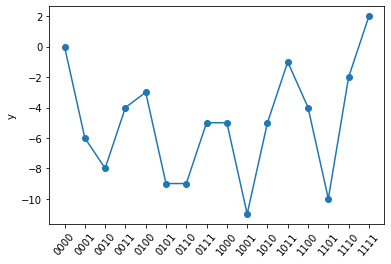

In [179]:
import matplotlib.pyplot as plt

value = []
binary = [bin(i)[2:].zfill(4) for i in range(16)]

for state in binary:
    value.append(qubo(state))
    
plt.plot(value,"o-")
plt.ylabel("y")


plt.xticks(range(16), binary, rotation=50);


In [ ]:
def qubo(state):
    """
    Calculates the value of QUBO problem for a bitstring
    Args : 
        State: Bitstring of length 4
        
    Returns:
        Value of QUBO for that bitstring
    
    """
    x1,x2,x3,x4 = str(state)
    x1 = int(x1); x2 = int(x2); x3 = int(x3); x4 = int(x4)

    y = -5*x1 -3*x2 -8*x3 - 6 *x4 + 4 * x1*x2 + 8 *x1*x3 + 2*x2*x3 + 10*x3*x4
    
    return y

def compute_expectation(counts,shots):
    """
    Calculates expectation value of a QUBO problem corresponding to circuit measurement
    Args:
        counts: Dictionary of measurement obtained from qiskit,
                containing states as keys, and associated probabilities to those states
        shots: total shots used for measurement
        
    Return:
        Expectation value of the QUBO for given measurement
    
    """
    exp = 0
    for state in counts:
        p = counts[state]/shots
        y = qubo(state)
        exp += p * y
    return exp

# Quantum Approximate Optimation Algorithm (QAOA)

In [181]:
def Hp(qc,gamma):
    """
    Creates the circuit corresponding to the problem unitary
    
    Args:
        qc : Initial circuit on which problem unitary is applied
        gamma : QAOA parameter for the problem unitary
    
    """
    ## RZ gates
    qc.rz(-2*0.5*gamma,0)
    qc.rz(-2*gamma,2)
    qc.rz(2*0.5*gamma,3)
    
    ## RZZ gates
    qc.rzz(2*2*gamma,0,1)
    qc.rzz(2*2*gamma,0,2)
    qc.rzz(2*0.5*gamma,1,2)
    qc.rzz(2*2.5*gamma,2,3)
    
def mixer(qc,beta):
    """
    Creates the circuit corresponding to the mixer unitary
    
    Args:
        qc : Initial circuit on which problem unitary is applied
        beta : QAOA parameter for the mixer unitary
    """
    for i in range(4):
        qc.rx(2 * beta, i)
        

In [221]:
def qaoa(param,p):
    """
    Gives the circuit corresponding to the qaoa problem (problem unitary +  mixer + measurement)
    
    Args:
        param: parameters gamma's and beta's. First p values correspond to gamma parameters,
               last p values correspond to beta parameters
        p: Repitions of qaoa circuit
        
    Returns:
        Full QAOA circuit
    """
    
    
    num_qubits = 4
    circuit = qt.QuantumCircuit(num_qubits)
    for i in range(num_qubits):
        circuit.h(i)
        
    gamma = param[:p]
    beta = param[p:]

    for i in range(p):
        Hp(circuit,gamma[i])
        mixer(circuit,beta[i])

    circuit.measure_all()
    
    return circuit

    
def get_expectation_QAOA(param, shots=1024):
    """
    Computes expectation of QUBO function corresponding to given QAOA params
    
    Args:
        param: parameters gamma's and beta's. First p values correspond to gamma parameters,
               last p values correspond to beta parameters
        shots: No. of shots used in measurement
    
    Returns:
        Expectation value of QUBO fucntion for the given QAOA params
        
    """

    qc = qaoa(param,p)
    backend = Aer.get_backend('aer_simulator')

    counts = backend.run(qc, seed_simulator=10,
                         shots=shots).result().get_counts()

    return compute_expectation(counts,shots)



# Optimizing QAOA parameters

In [242]:
from scipy.optimize import minimize

## Number of QAOA repetition
p = 6

## Minimize function from scipy used to find optimum qaoa params. Time function evaluates QAOA execution time
time1 = time.time()
res_qaoa = minimize(get_expectation_QAOA,[0.8,1.5]*p,method='COBYLA')
time2 = time.time()

time_qaoa = time2- time1
print(f"Time for executing QAOA circuit: {time_qaoa}s\n")

res_qaoa

Time for executing QAOA circuit: 16.834516525268555s



     fun: -8.4072265625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 149
  status: 1
 success: True
       x: array([1.55379277, 1.43282687, 0.83700843, 1.46903402, 0.84389678,
       1.29157695, 0.73536792, 1.50930347, 0.72449291, 1.57747242,
       0.70776817, 1.43539842])

Although optimum minization for function is at y=-11, for bitstring "1001", we obtain a higher function value here. This is because we get several bitstrings from our measurement (instead of just one correct answer). However, the highest probability bitstring is infact the correct solution to our problem

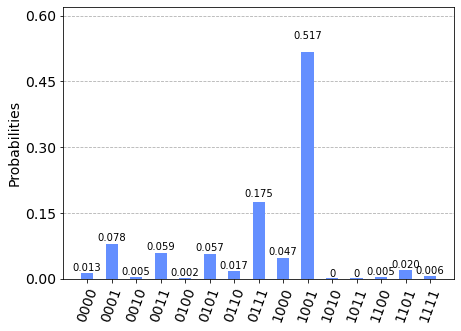

In [243]:
from qiskit.visualization import plot_histogram

qc = qaoa(res_qaoa.x,p)
counts = backend.run(qc, seed_simulator=10,shots=1024).result().get_counts()
plot_histogram(counts)

We obtained the correct bitstring "1001" with highest probablity of 0.517 for repetition value of p = 6.
QAOA is expected to converge as we increase the repetition. Increasing p value should provide higher probability of correct bit string.

# Variational Quantum Eigensolver (VQE)

In [216]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

def vqe(params):
    """
    Creates the VQE circuit 
    
    Args:
        params: List of length 3*qubits, with input parameters VQE gate
    
    Returns:
        Circuit for VQE
    """
    qubits = 4
    
    qr = QuantumRegister(qubits)
    cr = ClassicalRegister(qubits)
    qc = QuantumCircuit(qr, cr)
    
    qc.h(range(qubits))
    
    ## We dont need any entanglement since we are only looking for basis states
    ## in our optimum solution
    for i in range(4):
        qc.u(params[3*i], params[3*i + 1], params[3*i + 2], qr[i])
    
    qc.measure(qr, cr)
    return qc


def get_expectation_VQE(param, shots=1024):
    """
    Computes expectation of QUBO function corresponding to given VQE params
    
    Args:
        param: parameters gamma's and beta's. First p values correspond to gamma parameters,
               last p values correspond to beta parameters
        shots: No. of shots used in measurement
    
    Returns:
        Expectation value of QUBO fucntion for the given VQE params
        
    """

    qc = vqe(param)
    backend = Aer.get_backend('aer_simulator')

    counts = backend.run(qc, seed_simulator=10,
                         shots=shots).result().get_counts()

    return compute_expectation(counts,shots)

In [259]:
from scipy.optimize import minimize
import random

num_qubits = 4

## Minimize function from scipy used to find optimum vqe params. Time function evaluates VQE execution time
time1 = time.time()
res_VQE = minimize(get_expectation_VQE,[0.8,1.5]*6,method='COBYLA')
time2 = time.time()

time_vqe = time2-time1
print(f"Time for executing VQE circuit: {time_vqe}s.\n")

res_VQE

Time for executing VQE circuit: 17.892186164855957s.



     fun: -10.9482421875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 142
  status: 1
 success: True
       x: array([ 1.66078782,  0.81123976, -0.03006095,  1.63350039, -0.19284499,
        3.21082693,  1.77906811,  1.46612555,  2.92910687,  1.56756782,
        0.77442665, -0.07942941])

Minimum expectation value of function is obtained to be -10.9482 (instead of 11) This is because we get several bitstrings from our measurement (instead of just one correct answer). However, the highest probability bitstring ("1001") is infact the correct solution to our problem

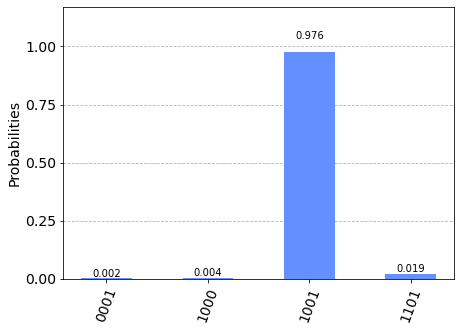

In [260]:
from qiskit.visualization import plot_histogram

qc = vqe(res_VQE.x)
counts = backend.run(qc, seed_simulator=10,shots=1024).result().get_counts()
plot_histogram(counts)

The correct bitstring is obtained with maximum probability of 0.976

# Comparison of QAOA and VQE

$\phantom{}$|QAOA |VQE
-----|-----|----- 
Time|16.8345s|17.8922s
Prob. of correct string|0.517  |0.976
No. of Params|12|12

The results of QAOA and VQE are mostly similar in terms of execution times and number of parameters used. Correct bit-string probabilty is higher for VQE. However, algorithm times are not properly comparable since they would change with change in initial parameters. The starting values used for both QAOA and VQE were chosen by hit-and-trial. Chosing initial parameters carefully will reduce execution time for both